In [2]:
import cdsapi
import numpy as np
import os 
c = cdsapi.Client()

area = [46.4, -122.4, 46, -122]
years = [str(ii) for ii in 1993 + np.arange(30)]
days = [str(ii) for ii in np.arange(31) + 1]
months = [str(ii) for ii in np.arange(12) + 1]

outfolder = '../climate data/larger_area'

# Snow depth water-equivalent

In [13]:

for year in years:
    c.retrieve(
        'reanalysis-era5-land',
        {
            'variable': 'snow_depth_water_equivalent',
            'year': year,
            'area': area,
            'time': '15:00',
            'day': days,
            'month': months,
            'format': 'grib',
        },
        os.path.join(outfolder, f'snow_depth_{year}.grib'))

2023-03-09 10:19:46,948 INFO Welcome to the CDS
2023-03-09 10:19:46,948 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-03-09 10:19:47,032 INFO Request is queued
2023-03-09 10:19:48,085 INFO Request is running
2023-03-09 10:21:02,464 INFO Request is completed
2023-03-09 10:21:02,466 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data6/adaptor.mars.internal-1678353587.8280277-17296-12-7b42cb0b-ac58-4ac4-b2fd-fca08da8f573.grib to ../climate data/larger_area/snow_depth_1993.grib (85.5K)
2023-03-09 10:21:03,621 INFO Download rate 74.1K/s
2023-03-09 10:21:03,727 INFO Welcome to the CDS
2023-03-09 10:21:03,728 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-03-09 10:21:03,814 INFO Request is queued
2023-03-09 10:21:04,871 INFO Request is running
2023-03-09 10:22:57,816 INFO Request is completed
2023-03-09 10:22:57,817 INFO Downloading https://

# Precipitation

In [92]:
for year in years:
    c.retrieve(
        'reanalysis-era5-land',
        {
            'variable': 'total_precipitation',
            'year': year,
            'area': area,
            'time': '10:00',
            'day': days,
            'month': months,
            'format': 'grib',
        },
        os.path.join(outfolder, f'precip_{year}.grib'))



2023-03-10 16:29:18,569 INFO Welcome to the CDS
2023-03-10 16:29:18,570 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-03-10 16:29:18,631 INFO Request is queued
2023-03-10 16:29:19,682 INFO Request is running
2023-03-10 16:30:34,011 INFO Request is completed
2023-03-10 16:30:34,013 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data9/adaptor.mars.internal-1678462159.6403785-11960-6-b09724cc-c938-42d0-8491-db206f9fb666.grib to ../climate data/larger_area/precip_2022.grib (85.5K)
2023-03-10 16:30:34,650 INFO Download rate 134.5K/s


Result(content_length=87600,content_type=application/x-grib,location=https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data9/adaptor.mars.internal-1678462159.6403785-11960-6-b09724cc-c938-42d0-8491-db206f9fb666.grib)

# Recombine & downsample

In [25]:
from datetime import date, datetime, timedelta
import os
from typing import Tuple
import locale
from copy import deepcopy

import matplotlib
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
import numpy as np
from obspy.core.inventory.inventory import read_inventory
from obspy.core.inventory.station import Station
import pygrib
import pandas as pd

def plot_clim_at_stat(
    data: np.ndarray, latv:np.ndarray, lonv:np.ndarray, stat: Station,
    dt: timedelta, dt2: timedelta,
    startdate: datetime, ylabel: str, title: str,
        tlim: Tuple[datetime, datetime], return_data=False):
    """
    Plots the dataset from the provided *grib* for the coordinates of the
    station. The dataset is assumed to span a time window.

    :param gribfile: *.grib* file containing climate data
    :type gribfile: str
    :param stat: Seismic Station
    :type stat: Station
    :param dt: Sampling interval
    :type dt: timedelta
    :param startdate: Time of first sample
    :type startdate: datetime
    :param ylabel: Ylabel
    :type ylabel: str
    :param title: Title for plot
    :type title: str
    :param tlim: time limits that define the x-axis limits
    :type tlim: Tuple[datetime, datetime]
    """
    
    # get coords
    slat = stat.latitude
    slon = stat.longitude
    idata = deepcopy(data)
    ilatv = deepcopy(latv)
    ilonv = deepcopy(lonv)
    return plot_clim_at_coords(
        idata, ilatv, ilonv, slat, slon, dt, dt2, startdate, ylabel,
        title, tlim, return_data)


def open_grib(gribfile: str):
    grbs = pygrib.open(gribfile)
    # This should be a time series on axis 0
    grb = grbs.select()
    data = np.array([g.values for g in grb])
    # Latitude and longitude grid
    lat, lon = grb[0].latlons()
    # make those vectors
    latv = lat[:, 0]
    lonv = lon[0, :]
    if np.all(lonv>180):
        lonv -= 360
    return data, latv, lonv


def plot_clim_at_coords(
    data: np.ndarray, latv: np.ndarray, lonv: np.ndarray, slat: float,
    slon: float, dt: timedelta, dt2: timedelta, startdate: datetime,
    ylabel: str = None, title: str = None,
        tlim: Tuple[datetime, datetime] = None, return_data=False):
    """
    Finds `slat` and `slon` in the grid plots a simple 2d line plot
    as a function of time.

    :param data: a 3D array with data for the following grid
        [time, lat, lon]
    :type data: np.ndarray
    :param latv: vector containing the latitudes of grid
    :type latv: np.ndarray
    :param lonv: vector containing the longitudes of grid
    :type lonv: np.ndarray
    :param slat: Latitude of the Station
    :type slat: float
    :param slon: Longitude of the Station
    :type slon: float
    :param dt: Sampling Interval
    :type dt: timedelta
    :param startdate: Time of first sample
    :type startdate: datetime
    :param ylabel: Ylabel, defaults to None
    :type ylabel: str, optional
    :param title: Title for plot, defaults to None
    :type title: str, optional
    :param tlim: time limits that define the x-axis limits
    :type tlim: Tuple[datetime, datetime]
    """
    set_mpl_params()
    ii = np.where(np.isclose(latv, round(slat, 1)))
    jj = np.where(np.isclose(lonv, round(slon, 1)))
    datav = np.squeeze(data[:, ii, jj])
    # Downsampling
    if dt2 is not None and dt2 > dt:
        decim = int(round(dt2/dt))
        datav = np.array(
            [datav[ii:ii+decim].sum() for ii in range(len(datav)//decim)])
        dt = dt2
    # Build time vector
    t = np.array([startdate + dt*i for i in range(len(datav))])
    # plt.plot(t, datav)
    if 'temperature' in ylabel.lower():
        # Go from Kelvin to celsius
        datav -= 273.15
    if return_data:
        return t, datav
    plt.bar(t, datav)
    ax = plt.gca()
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.xlabel('(dd/mm)')
    locale.setlocale(locale.LC_ALL, "en_GB.utf8")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %h'))
    plt.xticks(rotation='vertical')
    if tlim is not None:
        ax.set_xlim(tlim)
        # set ylim according to xlim
        visible_y = datav[np.where(np.logical_and(t > tlim[0], t < tlim[1]))]
        ax.set_ylim(np.min(visible_y), np.max(visible_y))


def set_mpl_params():
    params = {
        #'font.family': 'Avenir Next',
        'pdf.fonttype': 42,
        'font.weight': 'bold',
        'figure.dpi': 150,
        'figure.figsize': (12, 9),
        'figure.facecolor': 'None',
        'axes.labelweight': 'bold',
        'axes.linewidth': 1.5,
        'axes.labelsize': 14,
        'axes.titlesize': 18,
        'axes.titleweight': 'bold',
        'xtick.labelsize': 13,
        'xtick.direction': 'in',
        'xtick.top': True,  # draw label on the top
        'xtick.bottom': True,  # draw label on the bottom
        'xtick.minor.visible': True,
        'xtick.major.top': True,  # draw x axis top major ticks
        'xtick.major.bottom': True,  # draw x axis bottom major ticks
        'xtick.minor.top': True,  # draw x axis top minor ticks
        'xtick.minor.bottom': True,  # draw x axis bottom minor ticks
        'ytick.labelsize': 13,
        'ytick.direction': 'in',
        'ytick.left': True,  # draw label on the top
        'ytick.right': True,  # draw label on the bottom
        'ytick.minor.visible': True,
        'ytick.major.left': True,  # draw x axis top major ticks
        'ytick.major.right': True,  # draw x axis bottom major ticks
        'ytick.minor.left': True,  # draw x axis top minor ticks
        'ytick.minor.right': True,  # draw x axis bottom minor ticks
        'legend.fancybox': False,
        'legend.frameon': False,
        'legend.loc': 'upper left',
        'legend.numpoints': 2,
        'legend.fontsize': 'large',
        'legend.framealpha': 1,
        'legend.scatterpoints': 3,
        'legend.edgecolor': 'inherit',
    }
    matplotlib.rcParams.update(params)
    # matplotlib.font_manager._rebuild()
set_mpl_params()

## Snow

In [7]:
snows = []
for year in years:
    snow, latv, lonv = open_grib(f'../climate data/larger_area/snow_depth_{year}.grib')
    snows.append(snow)
snow = np.vstack(snows)

In [8]:
# time vector
t = np.array([datetime(int(years[0]), 1, 1) + i*timedelta(days=1) for i in range(snow.shape[0])])


## Precipitation

In [15]:
precips = []
for year in years:
    precip, latv, lonv = open_grib(f'../climate data/larger_area/precip_{year}.grib')
    precips.append(precip)
precip = np.vstack(precips)

print('This should be something between 1 and 2:', precip[:,3,3].sum(axis=0)/30)


This should be something between 1 and 2: 1.4407162843087815


## sanity check

(0.0, 0.36512017250061035)

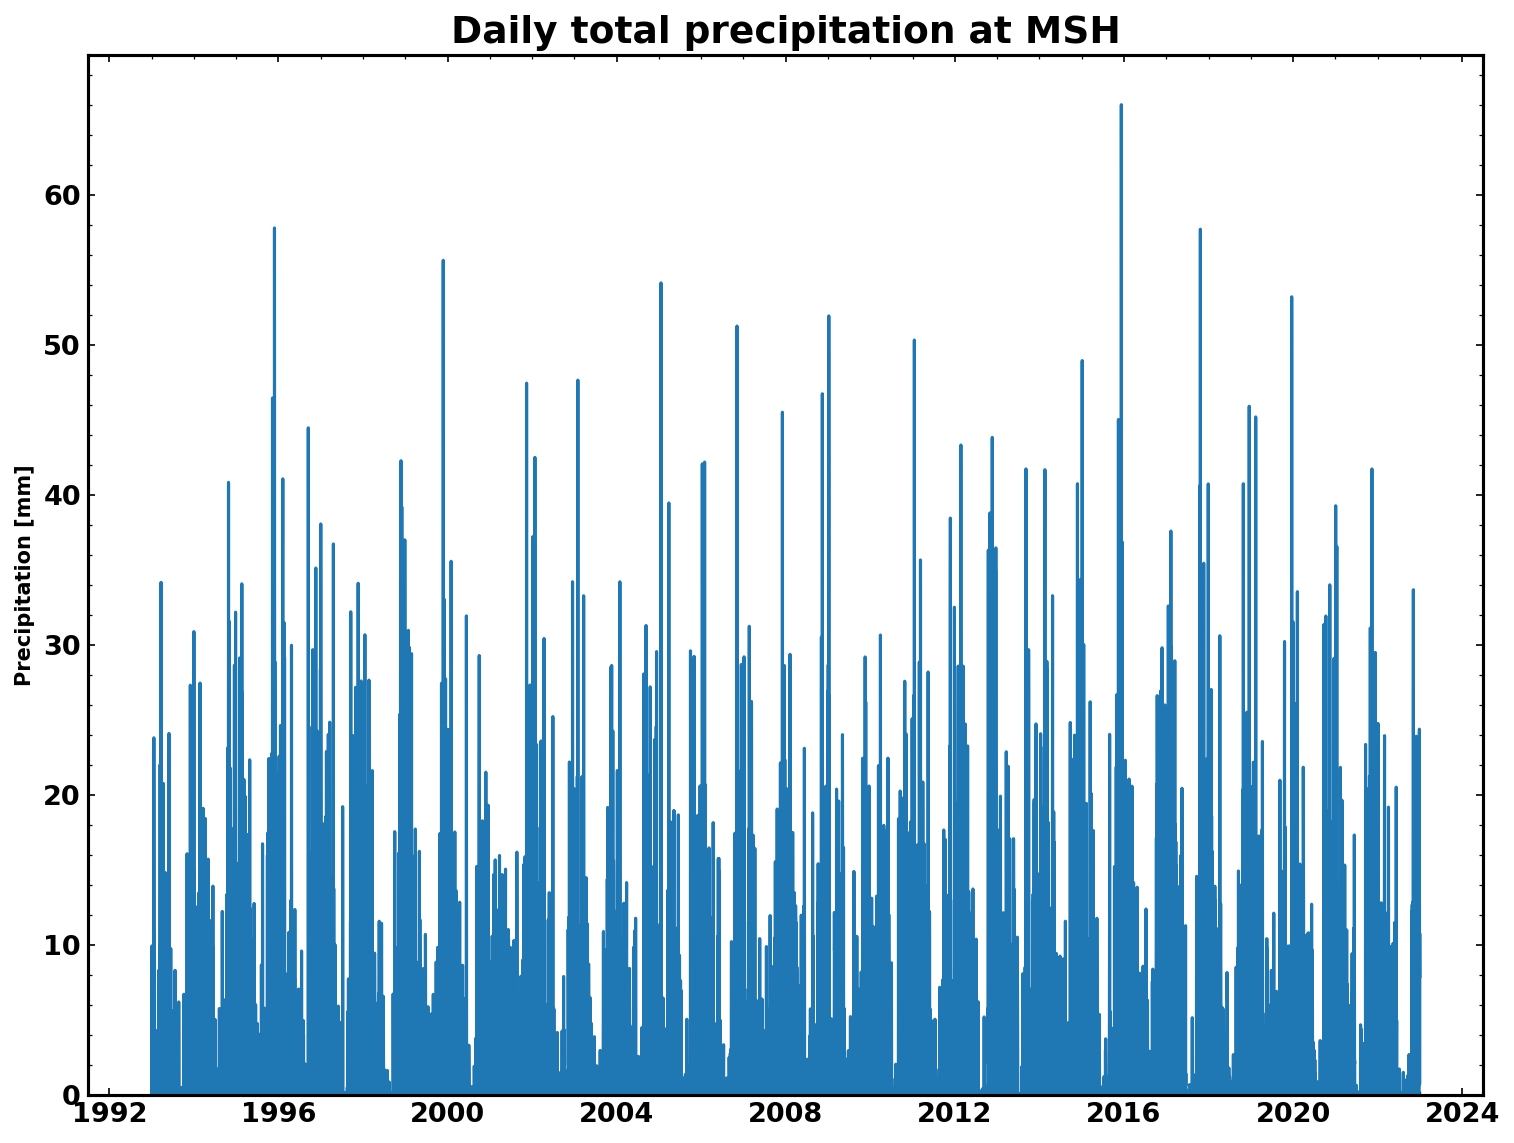

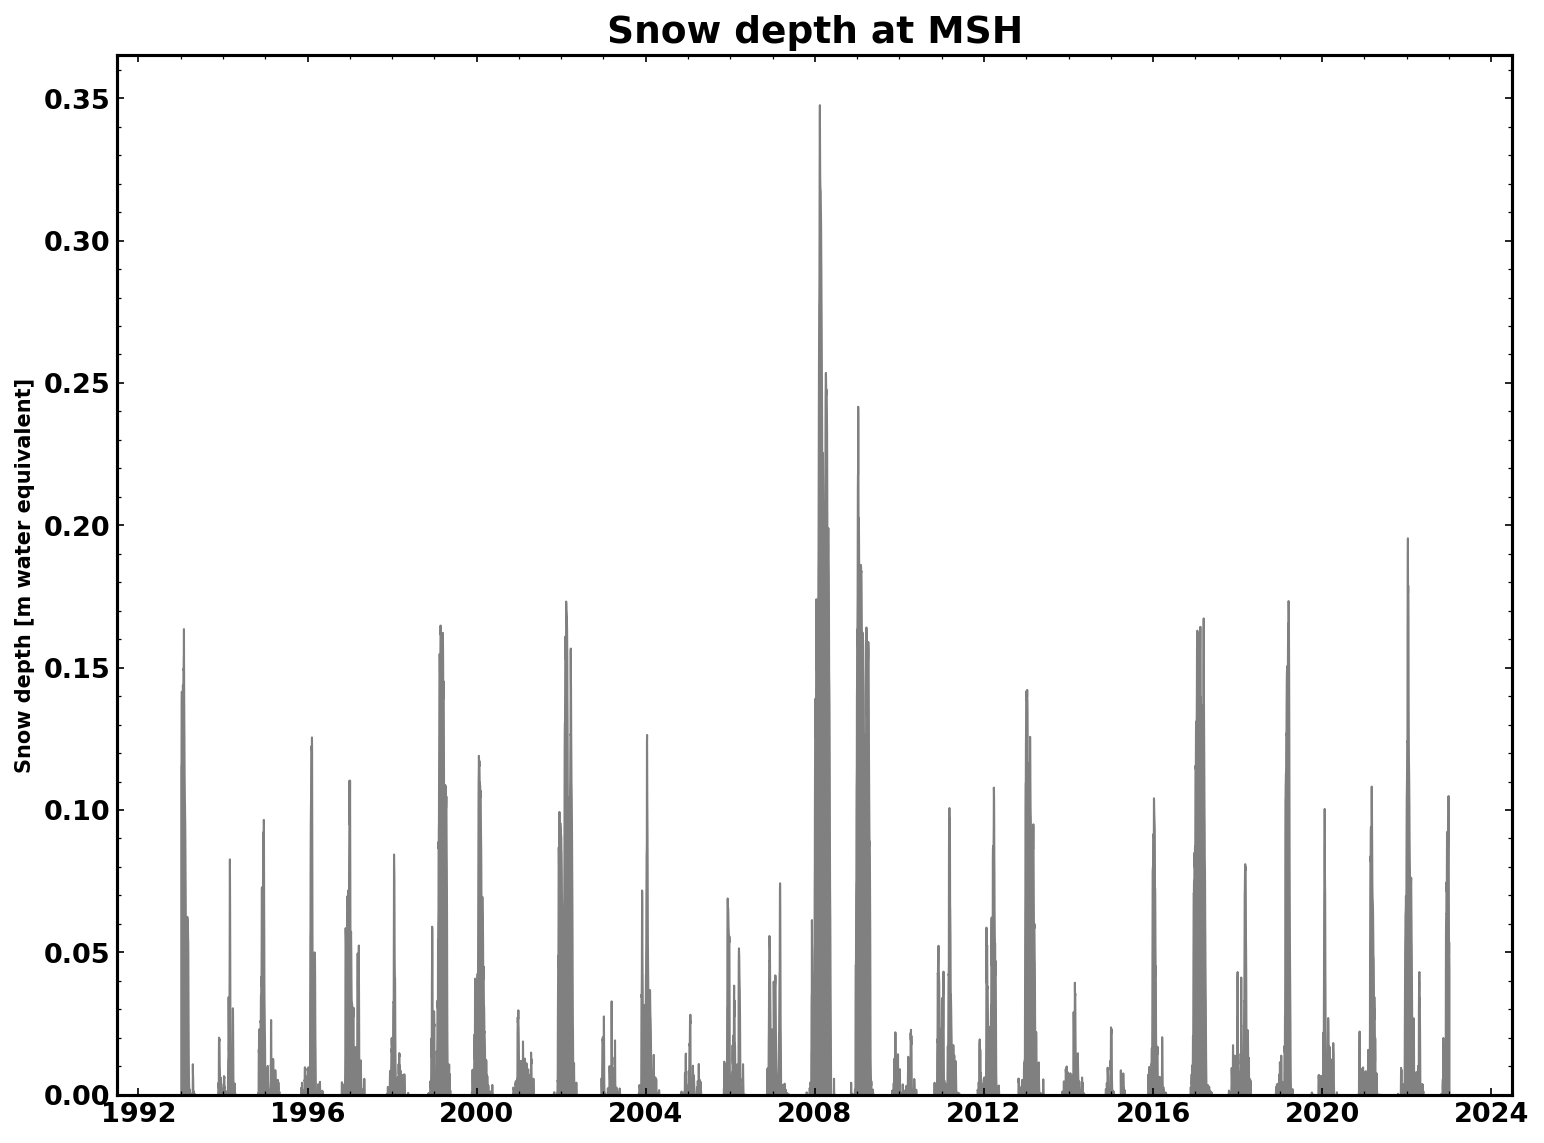

In [27]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(t, 1000*precip[:, 0, 0])
plt.title('Daily total precipitation at MSH')
plt.ylabel('Precipitation [mm]')
plt.ylim((0, None))

plt.figure(figsize=(12, 9))
plt.fill_between(t, snow[:, 0, 0], color='grey')
plt.title('Snow depth at MSH')
plt.ylabel('Snow depth [m water equivalent]')
plt.ylim((0, None))

## safe as csv

In [31]:
import pandas as pd
snowl, precipl, latl, lonl, datel = [], [], [], [], []
for ii, datum in enumerate(t):
    for jj, lat in enumerate(latv):
        for kk, lon in enumerate(lonv):
            snowl.append(snow[ii, jj, kk])
            precipl.append(precip[ii, jj, kk])
            latl.append(lat)
            lonl.append(lon)
            datel.append(datum)
d = {'snow_depth': snowl, 'total_precipitation': precipl, 'date': datel, 'latitude': latl, 'longitude': lonl}

df = pd.DataFrame(data=d)
df.to_csv(os.path.join(outfolder, 'climate_MSH.csv'))

# Do some plots and checks

In [51]:
# plot the total yearly precipitation and see whether there is a trend
snow_year = np.empty((len(years),))
precip_year = np.empty_like(snow_year)

for ii, year in enumerate(years):
    mask = np.array([int(year) == tt.year for tt in t])
    snow_year[ii] = np.mean(snow[mask, :,  :])
    precip_year[ii] = np.mean(precip[mask, :, : ].sum(axis=0))

(0.0, 1934.3729136706363)

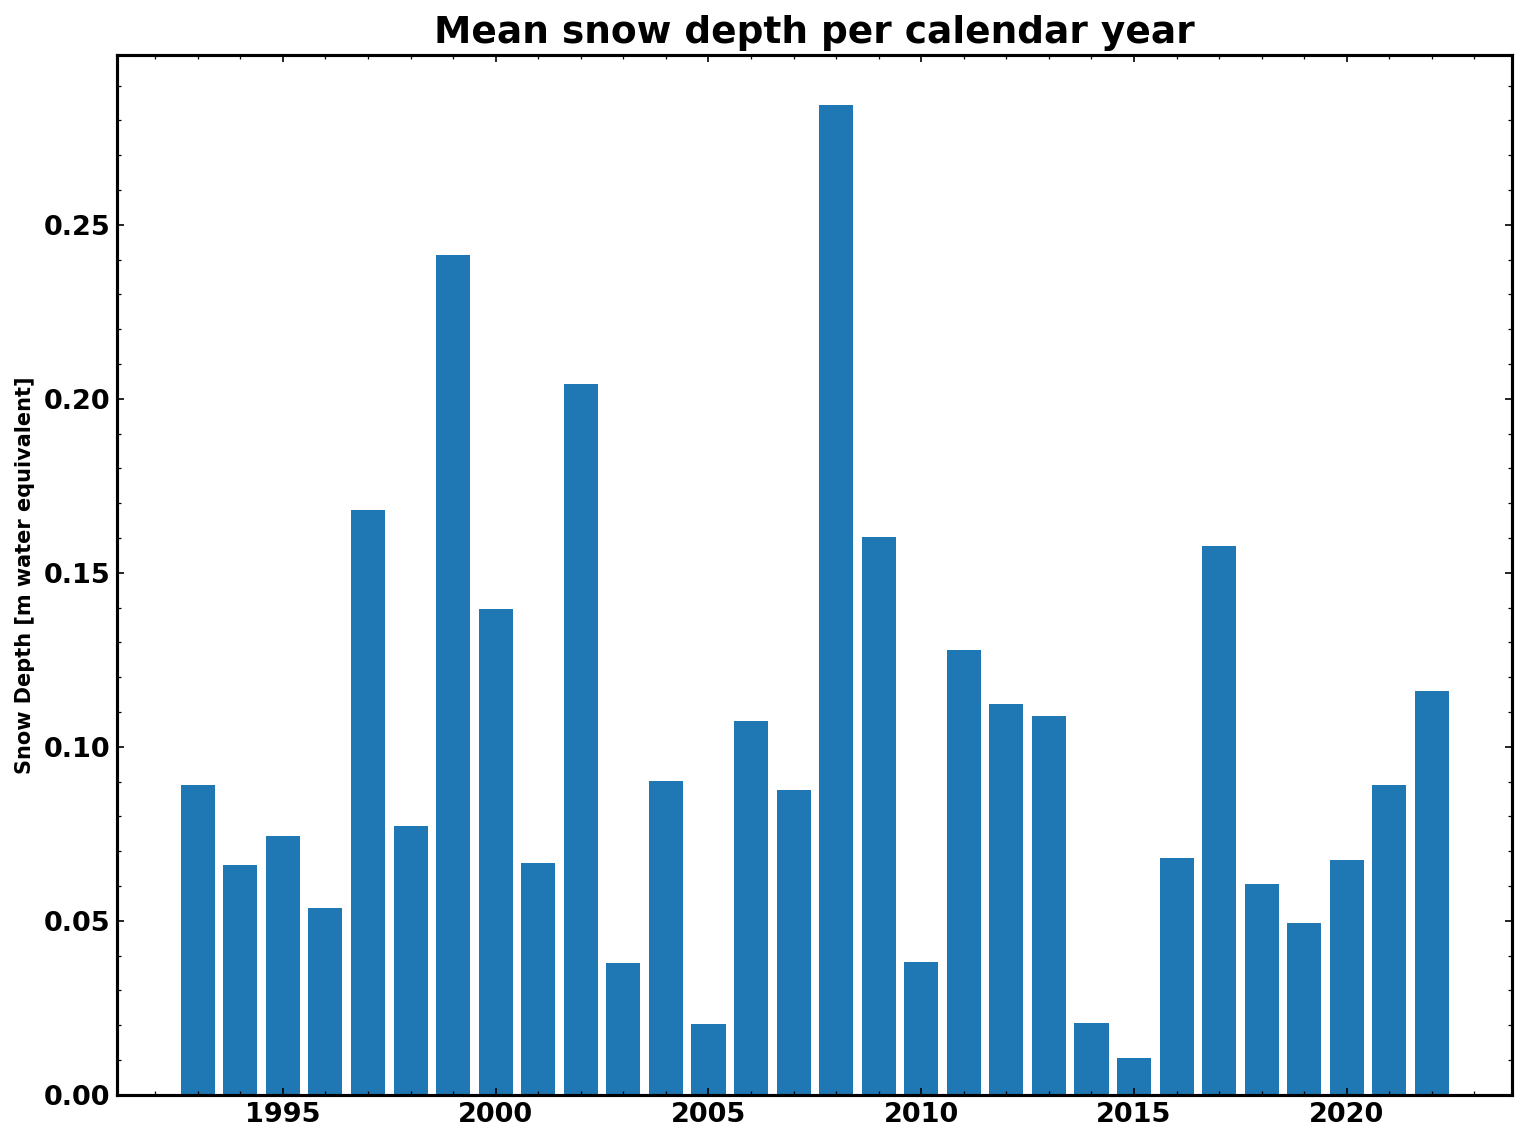

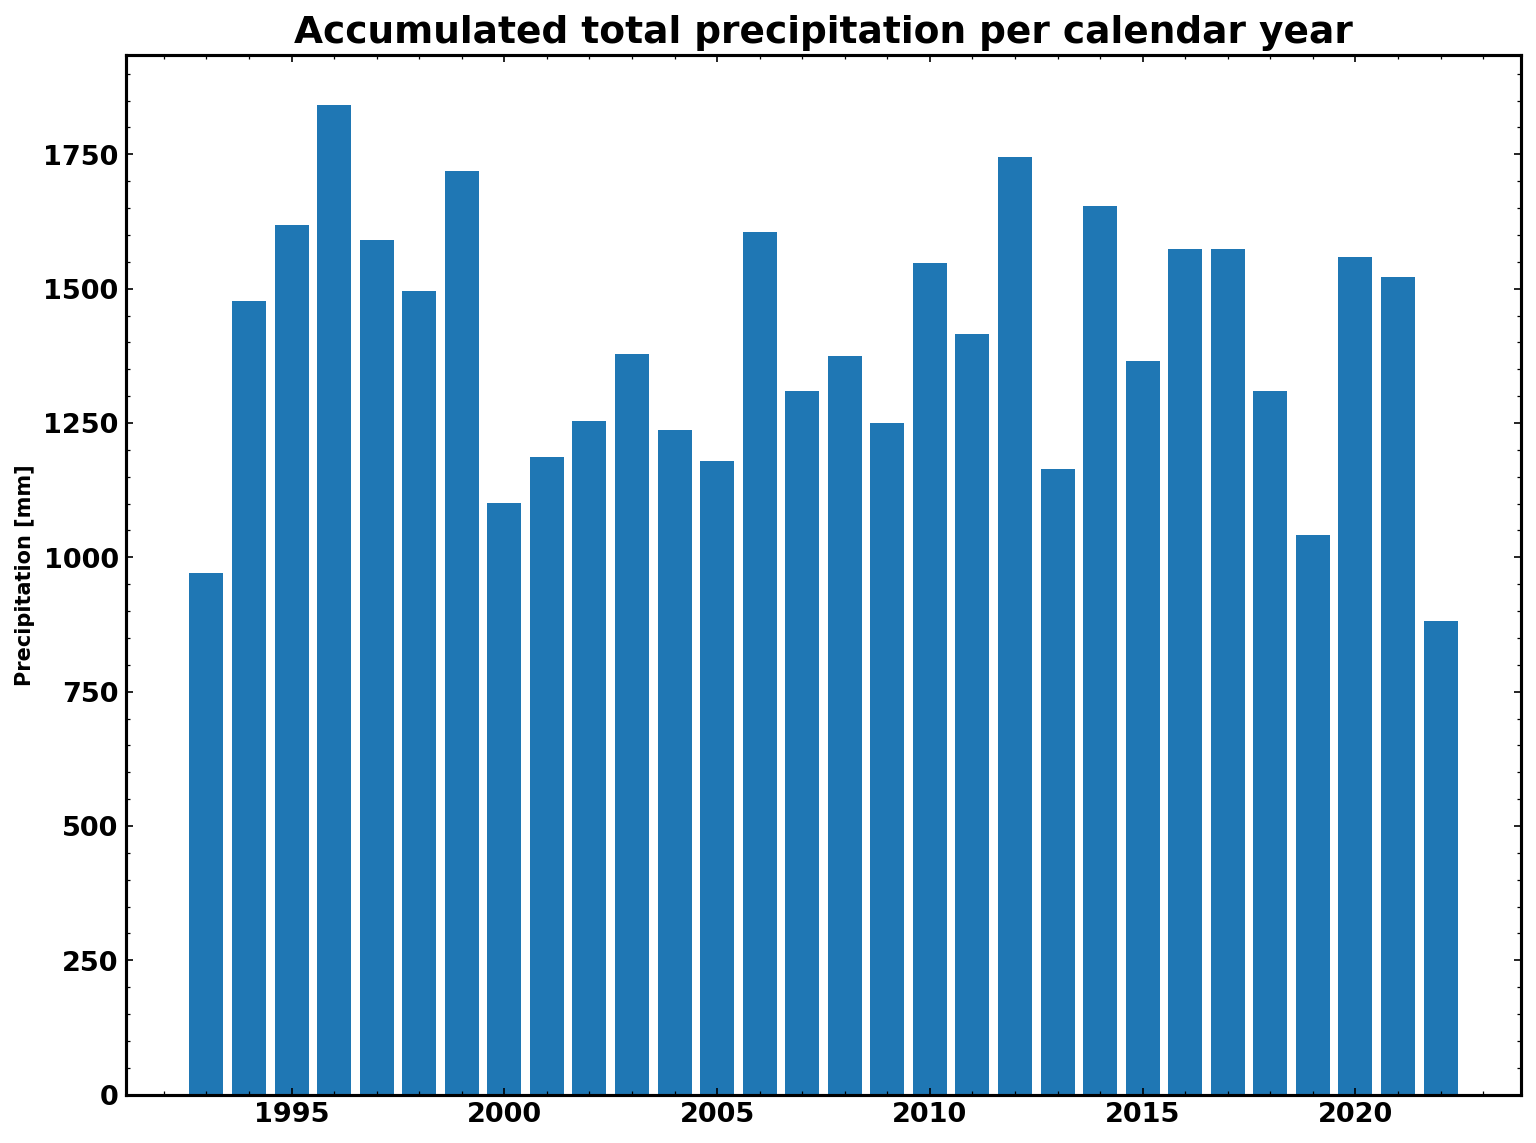

In [56]:
years_n = np.array([int(y) for y in years])

plt.figure()
plt.title('Mean snow depth per calendar year')
plt.ylabel('Snow Depth [m water equivalent]')
plt.bar(years_n, snow_year)
plt.ylim((0, None))

plt.figure()
plt.bar(years_n, precip_year*1000)
plt.title('Accumulated total precipitation per calendar year')
plt.ylabel('Precipitation [mm]')
plt.ylim((0, None))

Slope of snow accumulation  0.09981652955235777
Slope of precipitation  1398.0879446108643


(0.0, 44039.77025524223)

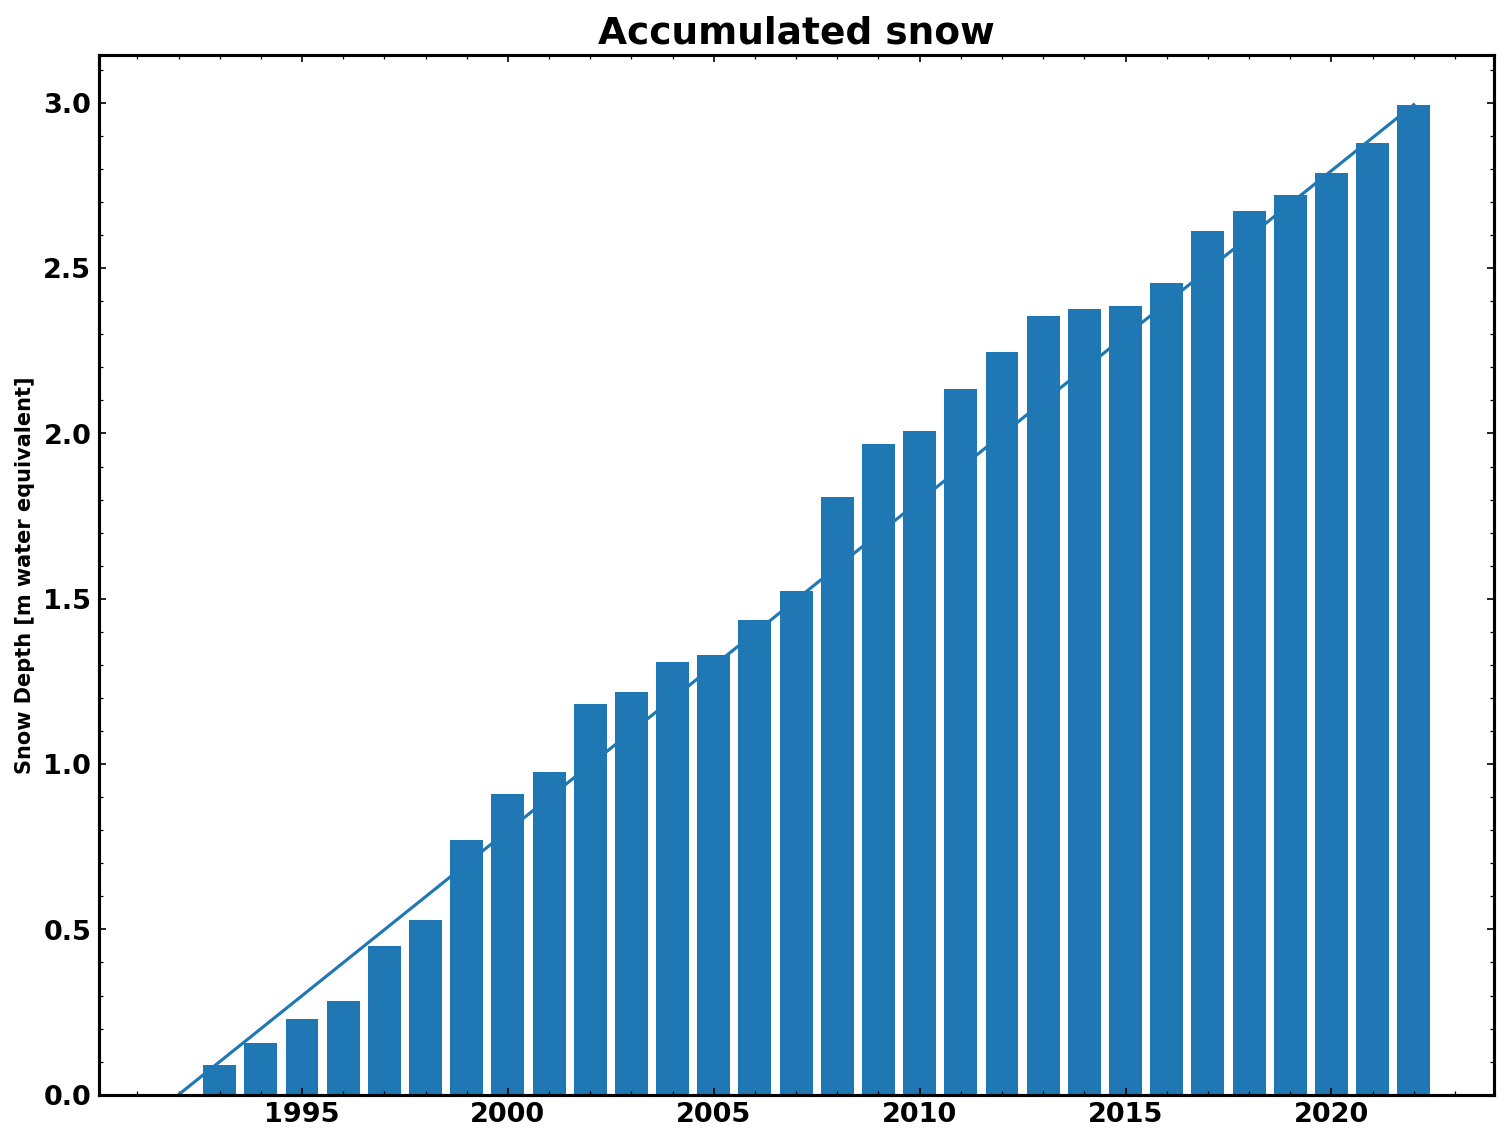

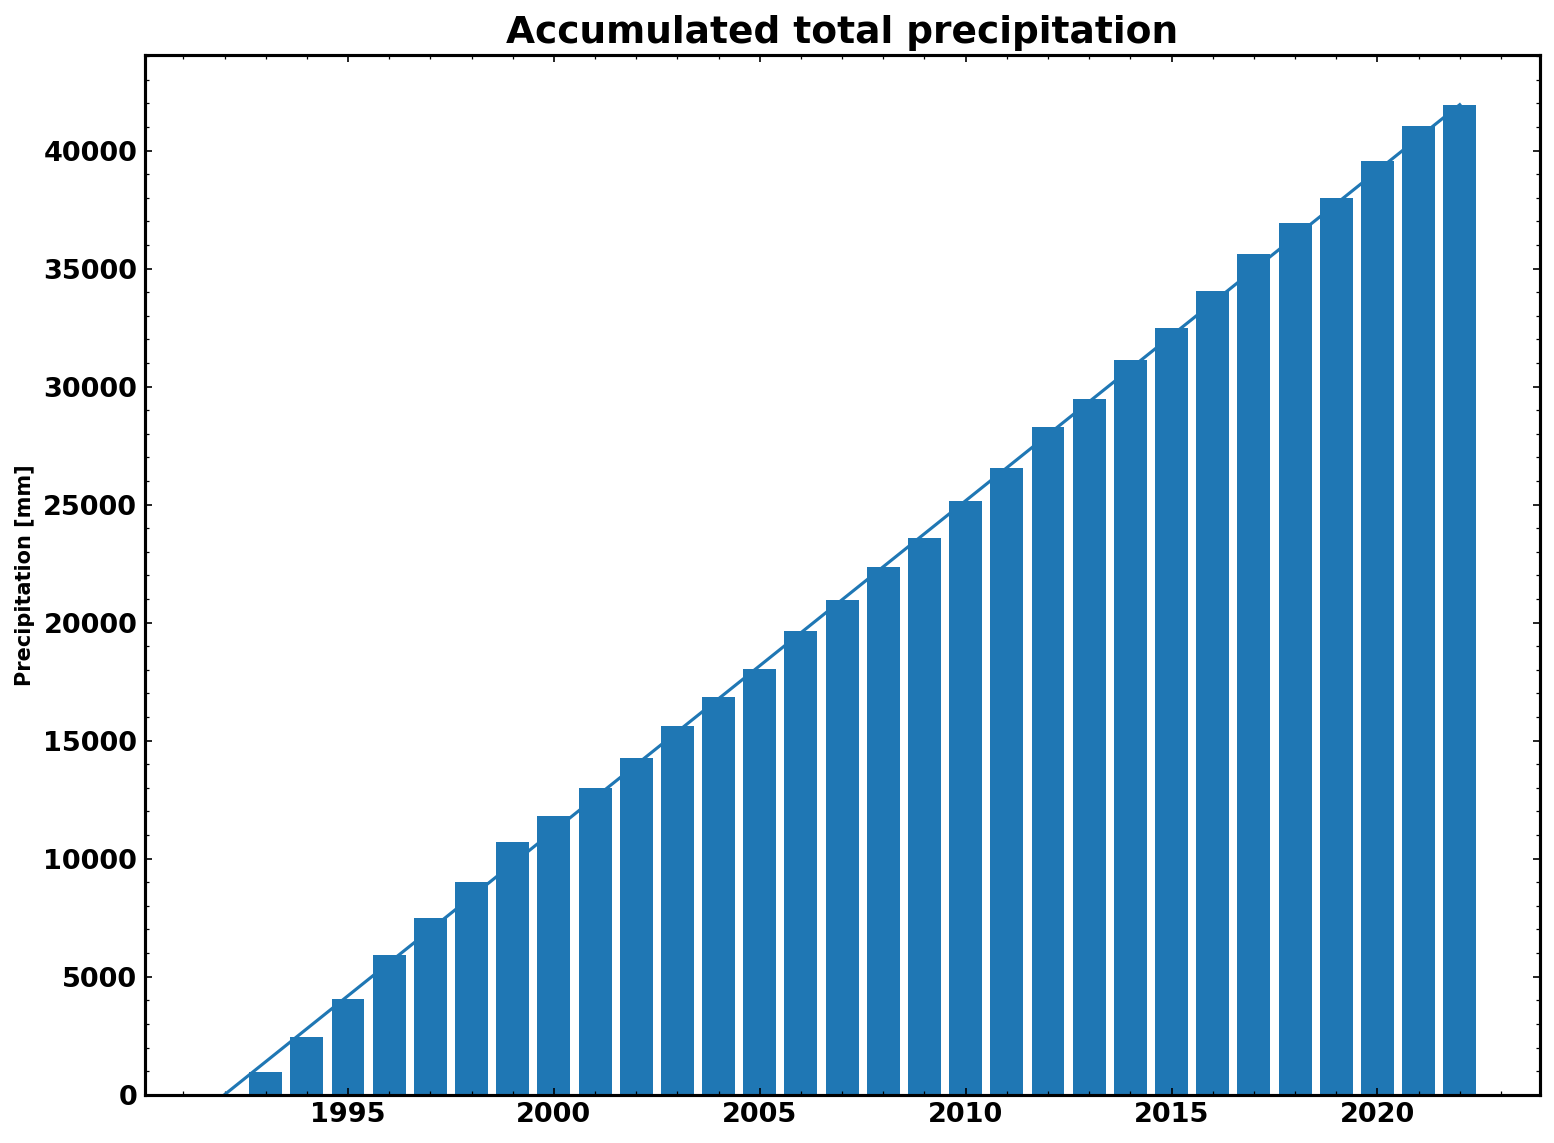

In [60]:
from scipy.stats import linregress

cum_years = np.hstack((1992, years_n))
cum_snow = np.hstack((0, np.cumsum(snow_year)))
cum_precip = np.hstack((0, np.cumsum(precip_year)))*1000

snow_slope = np.mean(np.diff(cum_snow))
print('Slope of snow accumulation ', snow_slope)
precip_slope = np.mean(np.diff(cum_precip))
print('Slope of precipitation ', precip_slope)


plt.figure()
plt.title('Accumulated snow')
plt.ylabel('Snow Depth [m water equivalent]')
plt.bar(cum_years, cum_snow)
plt.plot(cum_years, (cum_years-1992)*snow_slope)
plt.ylim((0, None))

plt.figure()
plt.bar(cum_years, cum_precip)
plt.plot(cum_years, (cum_years-1992)*precip_slope)
plt.title('Accumulated total precipitation')
plt.ylabel('Precipitation [mm]')
plt.ylim((0, None))